# LSTM

dataset: https://www.kaggle.com/datasets/chirag19/air-passengers

## Libraries

In [1]:
# Importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## Load Data & Cleaning Data

In [2]:
# Importing the Dataset as pandas dataframe

dataset=pd.read_csv('AirPassengers.csv')

In [3]:
# Column renaming
dataset.rename(columns={'#Passengers':'Passengers'},inplace=True)
dataset.rename(columns={'Month':'DATE'},inplace=True)
dataset.head(5)

,DATE,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
# 'DATE' column is converted from 'object' data type to 'datetime' 
dataset['DATE'] = pd.to_datetime(dataset['DATE'])
# 'DATE' column is set as dataset index
dataset=dataset.set_index(['DATE'])
data=dataset.copy()
data.head(12)

,Passengers
DATE,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


## Plot time-series

Text(0.5, 1.0, 'Passengers Time Series')

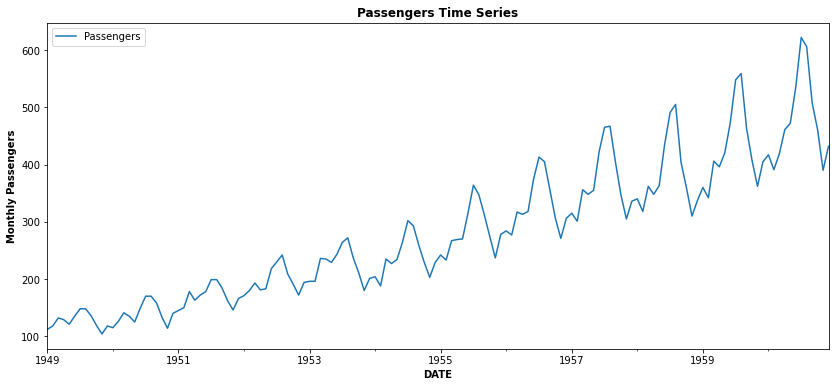

In [5]:
# Time Series Plot
data.plot(figsize=(14,6))
plt.xlabel('DATE',fontweight='bold')
plt.ylabel('Monthly Passengers',fontweight='bold');
plt.title('Passengers Time Series',fontweight='bold')

## Split data & Normalization

In [6]:
# Test size: 12 months
test_size = 12
# Dataset is split into training and test data
train = data.iloc[:len(dataset)- test_size]
test = data.iloc[-test_size:]

In [7]:
# Scaling the training and test data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [8]:
# Importing the keras library and the TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [9]:
# Training Batch length
length = 11
# No. of features
n_features=1
# Creating the time series generator
time_series_generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [10]:
# First batch of the time_series_generator- training and test values
InpSeq,TargetVal=time_series_generator[0]
# At the first batch, the generator takes the first 11 samples to predict the next sample
print(InpSeq,TargetVal)

[[[0.01758242]
  [0.03076923]
  [0.06153846]
  [0.05494505]
  [0.03736264]
  [0.06813187]
  [0.0967033 ]
  [0.0967033 ]
  [0.07032967]
  [0.03296703]
  [0.        ]]] [[0.03076923]]


In [11]:
# The TargetVal of the time_series_generator first batch corresponds to the 12th [index 11] value of the scaled training data
print(TargetVal)
print(scaled_train[11])

[[0.03076923]]
[0.03076923]


## Training LSTM

In [12]:
# Importing the necessary libraries to create/construct the deep neural network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras import initializers
import tensorflow as tf
from keras.layers import Bidirectional

In [13]:
# Use of random seed to get the same results at every run
tf.random.set_seed(0)
np.random.seed(0)

In [14]:
# Use of the he_uniform initializer to set the initial random weights of the model layers. 
initializer = tf.keras.initializers.he_uniform(seed=0)
model = Sequential() # Initially, the network model is defined 
# Selected Activation function has been the rectified linear unit
model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(length, n_features),kernel_initializer=initializer))) 
# The output layer consists of 1 neuron with a 'linear' activation fuction 
model.add(Dense(1,activation='linear',kernel_initializer=initializer))
# The model is compiled using MSE as  loss function and Adam as optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')
# A validation generator is constructed in a similar way to the previous time_series_generator with the only difference being
# the use of scaled_test values for validation purposes
time_series_val_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)                

In [15]:
# The model is trained for n-epochs. At each epoch both training and validation losses can be observed/ lets see n- epochs
model.fit_generator(time_series_generator,epochs=30,shuffle=False,
                    validation_data=time_series_val_generator, verbose=0) 

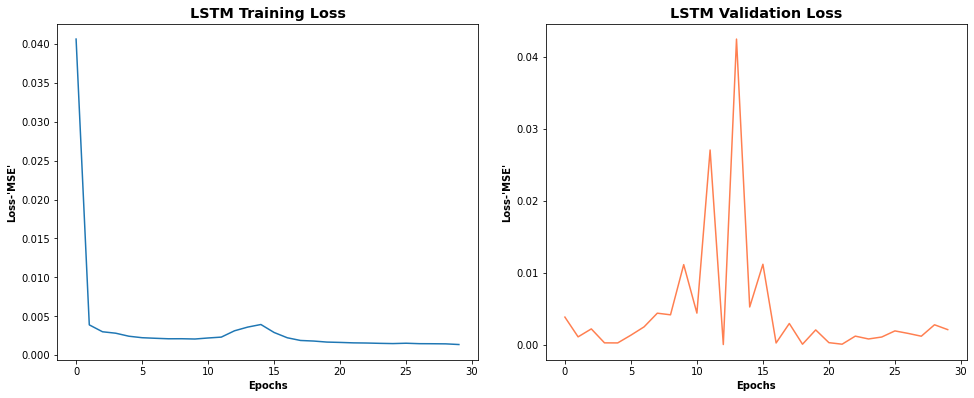

In [16]:
# Training and validation loss plots
fig,axs=plt.subplots(1,2,figsize=(14,6))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size']=12
train_loss = pd.DataFrame(model.history.history)
train_loss.loss.plot(ax=axs[0])
axs[0].set_title('LSTM Training Loss',fontweight='bold')
train_loss.val_loss.plot(ax=axs[1],color='coral')
axs[1].set_title('LSTM Validation Loss',fontweight='bold')
for ax in axs.flat:
    ax.set_xlabel('Epochs',fontweight='bold')
    ax.set_ylabel("Loss-'MSE'",fontweight='bold')

   
    ax.figure.tight_layout(pad=2)

## LSTM Predictions on the Training Set

In [17]:
# Determining all LSTM outputs
training_outputs = []
batch = scaled_train[:length].reshape((1, length, n_features))

for i in range(len(scaled_train[length:])):
    train_out = model.predict(batch)[0]
    training_outputs.append(train_out) 
    batch = np.append(batch[:,1:,:],[[scaled_train[length:][i]]],axis=1)

1/1 [==============================] - 0s 45ms/step


In [18]:
#Inverse transforming the expected values
actual_train=scaled_train[length:]
actual_train=scaler.inverse_transform(actual_train)

In [19]:
# Inverse transforming the LSTM predictions on the training set
train_predictions=scaler.inverse_transform(training_outputs)

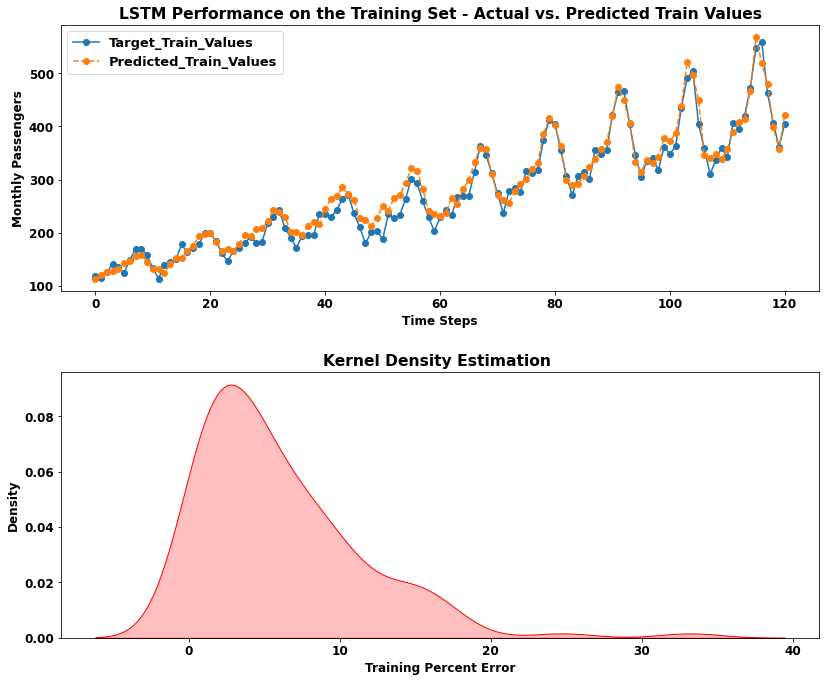

In [20]:
#'LSTM Performance on the training set - Actual vs. Predicted Values'
fig,axs=plt.subplots(2,1,figsize=(12,10))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size']=13

axs[0].plot(actual_train,marker='o',linestyle='-',label='Target_Train_Values')

axs[0].plot(train_predictions,marker='o',linestyle='dashed',label='Predicted_Train_Values')
axs[0].set_title('LSTM Performance on the Training Set - Actual vs. Predicted Train Values',fontweight='bold')

axs[0].legend()
axs[0].set_xlabel('Time Steps',fontweight='bold')
axs[0].set_ylabel('Monthly Passengers',fontweight='bold');

# Training percent error distribution plot
train_err=abs((actual_train-train_predictions)/actual_train)*100
train_err=pd.DataFrame(train_err,columns=['Training Error'])

sns.kdeplot(train_err['Training Error'],shade=True,color='r',kernel='gau',ax=axs[1])
axs[1].set_xlabel('Training Percent Error',fontweight='bold')
axs[1].set_ylabel('Density',fontweight='bold');
axs[1].set_title('Kernel Density Estimation ',fontweight='bold')
for ax in axs.flat:
    ax.figure.tight_layout(pad=2);

In [21]:
# Summary statistics of training percent error
train_err.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Training Error,121.0,6.03482,5.440277,0.082992,2.071383,4.464348,8.474228,33.209009


## LSTM Predictions on the Test Set

In [22]:
# Determining all LSTM outputs 
test_outputs = []
batch_test = scaled_train[-length:].reshape((1, length, n_features))

for i in range(len(test)):
    test_out = model.predict(batch_test)[0]
    test_outputs.append(test_out) 
    batch_test = np.append(batch_test[:,1:,:],[[test_out]],axis=1)

1/1 [==============================] - 0s 48ms/step


In [23]:
# Inverse transforming the LSTM predicitons
lstm_predictions = scaler.inverse_transform(test_outputs)

In [24]:
# A new test feature is created to comprise the LSTM test predictions
test['LSTM Predictions'] = lstm_predictions.round(2)

In [25]:
# test(Actual) and LSTM Predictions
test

,Passengers,LSTM Predictions
DATE,,
1960-01-01,417,378.38
1960-02-01,391,413.72
1960-03-01,419,433.40
1960-04-01,461,476.55
1960-05-01,472,479.32
1960-06-01,535,514.92
1960-07-01,622,614.39
1960-08-01,606,577.85
1960-09-01,508,558.93


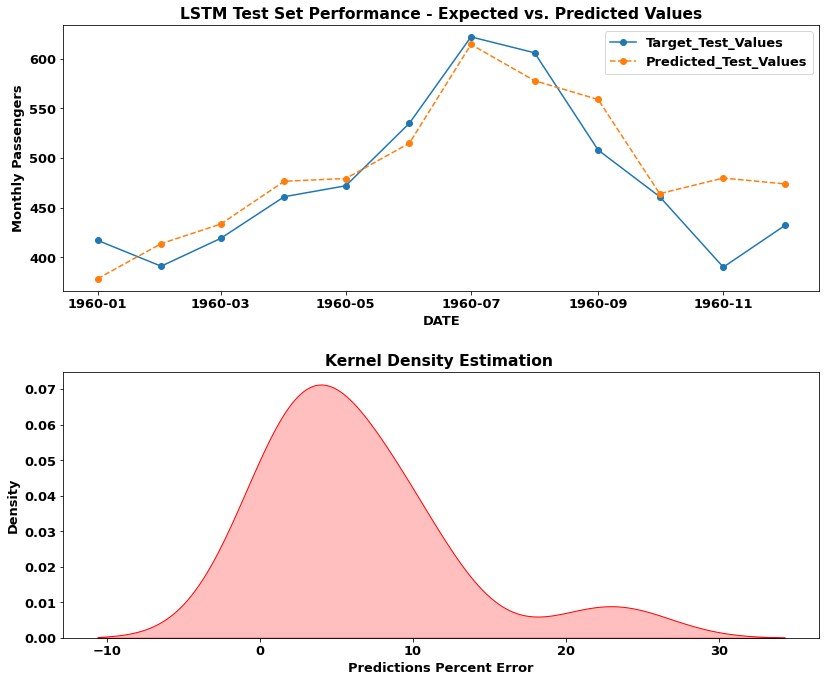

In [26]:
# Plot of the Test vs. Predicted values for a prediction horizon of 12 months 
fig,axs=plt.subplots(2,1,figsize=(12,10))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size']=13

axs[0].plot(test['Passengers'],marker='o',linestyle='-',label='Target_Test_Values')

axs[0].plot(test['LSTM Predictions'],marker='o',linestyle='dashed',label='Predicted_Test_Values')
axs[0].set_title('LSTM Test Set Performance - Expected vs. Predicted Values',fontweight='bold')

axs[0].legend()
axs[0].set_xlabel('DATE',fontweight='bold')
axs[0].set_ylabel('Monthly Passengers',fontweight='bold');

# LSTM Predictions percent Error distribution plot
test_err=abs((test['Passengers']-test['LSTM Predictions'])/test['Passengers'])*100
test_err=pd.DataFrame(test_err,columns=['Test Set Error'])

sns.kdeplot(test_err['Test Set Error'],shade=True,color='r',kernel='gau',ax=axs[1])
axs[1].set_xlabel('Predictions Percent Error',fontweight='bold')
axs[1].set_ylabel('Density',fontweight='bold');
axs[1].set_title('Kernel Density Estimation ',fontweight='bold')
for ax in axs.flat:
    ax.figure.tight_layout(pad=2);

In [27]:
# Summary statistics of LSTM predictions percent error
test_err.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Test Set Error,12.0,6.371454,6.180409,0.661605,2.917538,4.199243,9.368497,23.025641


In [28]:
# Importing the metrics
from sklearn.metrics import mean_squared_error
# Root Mean Squared Error
print(np.sqrt(mean_squared_error(test['Passengers'],test['LSTM Predictions'])))

36.72357973201051


In [29]:
# Creating an index for the LSTM predictions on the Training Set
train_index=pd.date_range(start='1949-12-01',periods=121,freq='M')

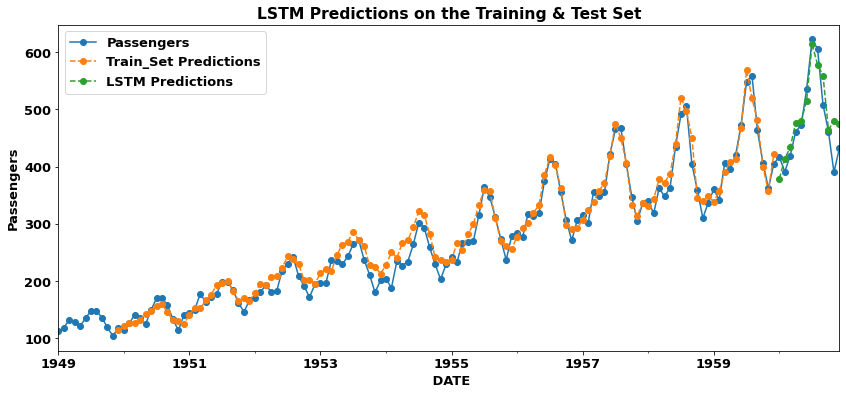

In [30]:
# Converting the train_predictions from np.ndarray to pandas dataframe
train_df=pd.DataFrame(data=train_predictions,index=train_index,columns=['Train_Set Predictions'])

# Plot comprising the original time series and the LSTM predictions on the Training and Test Set
ax=data.plot(figsize=(14,6),marker='o',linestyle='-')

train_df.plot(ax=ax,marker='o',linestyle='--',legend=True)
test['LSTM Predictions'].plot(ax=ax,legend=True,marker='o',linestyle='dashed')
plt.title('LSTM Predictions on the Training & Test Set',fontweight='bold')
plt.ylabel('Passengers',fontweight='bold')
plt.xlabel(' DATE',fontweight='bold');

## Monthly Passengers future forecast using LSTM

In [31]:
data.tail()

,Passengers
DATE,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [32]:
# A new scaler is being initialized
data_scaler=MinMaxScaler()
# fit_transform function applied to all dataset's entries
scaled_set=data_scaler.fit_transform(data)
# A new TimeseriesGenerator is created to include the new scaled values, (batch_size = 1 , length=12)
length=12
data_generator=TimeseriesGenerator(scaled_set,scaled_set,length=length,batch_size=1)

In [33]:
# Use of random seed to get the same results at every run
tf.random.set_seed(0)
np.random.seed(0)

In [34]:
# The LSTM model is constructed and compiled 
# Since the model forecasts into the future, in this case there is no presence of validation data 

initializer = tf.keras.initializers.he_uniform(seed=0)
model=Sequential()
model.add(Bidirectional(LSTM(100,activation='relu',input_shape=(length,n_features),kernel_initializer=initializer)))                     
model.add(Dense(1,activation='linear',kernel_initializer=initializer))                   
model.compile(optimizer=opt,loss='mse')
model.fit_generator(data_generator,epochs=30,shuffle=False)

Epoch 1/30
132/132 [==============================] - 8s 13ms/step - loss: 0.0215
Epoch 2/30
132/132 [==============================] - 2s 14ms/step - loss: 0.0049
Epoch 3/30
132/132 [==============================] - 2s 14ms/step - loss: 0.0021
Epoch 4/30
132/132 [==============================] - 2s 13ms/step - loss: 0.0015
Epoch 5/30
132/132 [==============================] - 2s 14ms/step - loss: 0.0013
Epoch 6/30
132/132 [==============================] - 2s 14ms/step - loss: 0.0014
Epoch 7/30
132/132 [==============================] - 2s 14ms/step - loss: 0.0013
Epoch 8/30
132/132 [==============================] - 2s 14ms/step - loss: 0.0013
Epoch 9/30
132/132 [==============================] - 2s 13ms/step - loss: 0.0013
Epoch 10/30
132/132 [==============================] - 2s 13ms/step - loss: 0.0013
Epoch 11/30
132/132 [==============================] - 2s 14ms/step - loss: 0.0013
Epoch 12/30
132/132 [==============================] - 2s 14ms/step - loss: 0.0013
Epoch 13/30
1

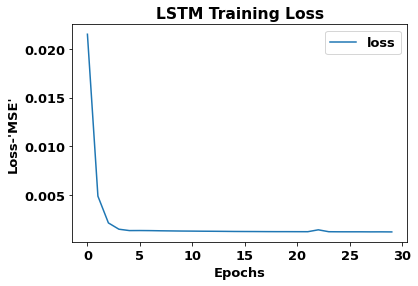

In [35]:
# Training Performance
loss=pd.DataFrame(model.history.history)
loss.plot()
plt.title('LSTM Training Loss',fontweight='bold')
plt.xlabel('Epochs',fontweight='bold')
plt.ylabel("Loss-'MSE'",fontweight='bold');

In [36]:
# Determining all LSTM predictions on the Training Set 
full_training_outputs = []
batch = scaled_set[:length].reshape((1, length, n_features))

for i in range(len(scaled_set[length:])):
    full_train_out = model.predict(batch)[0]
    full_training_outputs.append(full_train_out) 
    batch = np.append(batch[:,1:,:],[[scaled_set[length:][i]]],axis=1)

1/1 [==============================] - 0s 42ms/step


In [37]:
# Inverse transforming the actual training values
f_train=scaled_set[length:]
f_train=scaler.inverse_transform(f_train)

In [38]:
# Inverse transforming the LSTM predictions on the training set
f_train_predictions=scaler.inverse_transform(full_training_outputs)

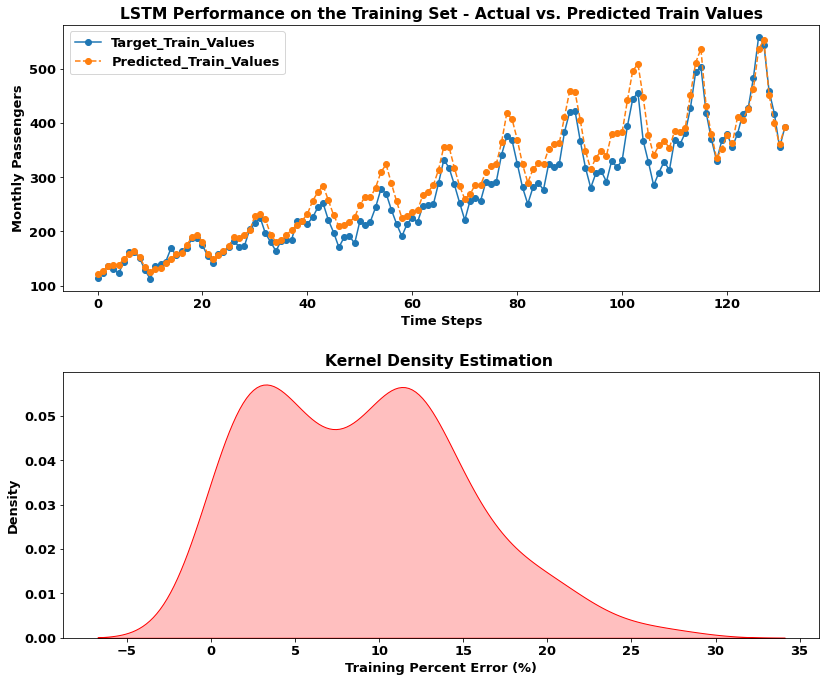

In [39]:
#'LSTM Training Performance - Actual vs. Predicted Training Values'
fig,axs=plt.subplots(2,1,figsize=(12,10))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size']=13

axs[0].plot(f_train,marker='o',linestyle='-',label='Target_Train_Values')

axs[0].plot(f_train_predictions,marker='o',linestyle='dashed',label='Predicted_Train_Values')
axs[0].set_title('LSTM Performance on the Training Set - Actual vs. Predicted Train Values',fontweight='bold')

axs[0].legend()
axs[0].set_xlabel('Time Steps',fontweight='bold')
axs[0].set_ylabel('Monthly Passengers',fontweight='bold');

# Training Percent Error distribution plot
f_train_err=abs((f_train-f_train_predictions)/f_train)*100
f_train_err=pd.DataFrame(f_train_err,columns=['Training Error'])

sns.kdeplot(f_train_err['Training Error'],shade=True,color='r',kernel='gau',ax=axs[1])
axs[1].set_xlabel('Training Percent Error (%)',fontweight='bold')
axs[1].set_ylabel('Density',fontweight='bold');
axs[1].set_title('Kernel Density Estimation ',fontweight='bold')
for ax in axs.flat:
    ax.figure.tight_layout(pad=2);

In [40]:
# Summary statistics of the LSTM Prediction Error with respect to its Training Set Perfomance
f_train_err.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Training Error,132.0,8.923306,6.083566,0.12153,3.722934,8.909945,12.630419,27.248672


In [41]:
# Mean Squared Error
print(np.sqrt(mean_squared_error(f_train,f_train_predictions)))

29.359818904999585


In [42]:
# Creating an index for the LSTM predictions on the Training Set
f_train_index=pd.date_range(start='1949-12-01',periods=132,freq='M')

In [43]:
# Converting the LSTM predictions from np.ndarray to pandas dataframe
f_train_df=pd.DataFrame(data=f_train_predictions,index=f_train_index,columns=['Predicted_Train'])

In [44]:
# Obtaining the LSTM forecasted values 
lstm_outputs=[]
batch = scaled_set[-length:].reshape((1, length, n_features))

for i in range(length):
    lstm_out = model.predict(batch)[0]
    lstm_outputs.append(lstm_out) 
    batch = np.append(batch[:,1:,:],[[lstm_out]],axis=1)

1/1 [==============================] - 0s 53ms/step


In [45]:
# Inverse transforming the LSTM forecasts
lstm_outputs=data_scaler.inverse_transform(lstm_outputs)
lstm_outputs

array([[454.37498689],
       [426.35867059],
       [447.19282734],
       [490.97951961],
       [497.83017206],
       [544.37383497],
       [645.34356999],
       [639.91731429],
       [524.65118563],
       [478.18057346],
       [409.6619767 ],
       [446.74303734]])

In [46]:
data.tail

<bound method NDFrame.tail of             Passengers
DATE                  
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]>

In [47]:
# Creating an index for the LSTM forecasts
lstm_forecast_index=pd.date_range(start='1961-01-01',periods=12,freq='M')

In [48]:
# Converting the lstm_outputs from np.ndarray to pandas dataframe
lstm_forecast_df=pd.DataFrame(data=lstm_outputs,index=lstm_forecast_index,columns=['LSTM Forecasts'])
lstm_forecast_df

,LSTM Forecasts
1961-01-31,454.374987
1961-02-28,426.358671
1961-03-31,447.192827
1961-04-30,490.979520
1961-05-31,497.830172
1961-06-30,544.373835
1961-07-31,645.343570
1961-08-31,639.917314
1961-09-30,524.651186
1961-10-31,478.180573


Text(0.5, 0, ' DATE')

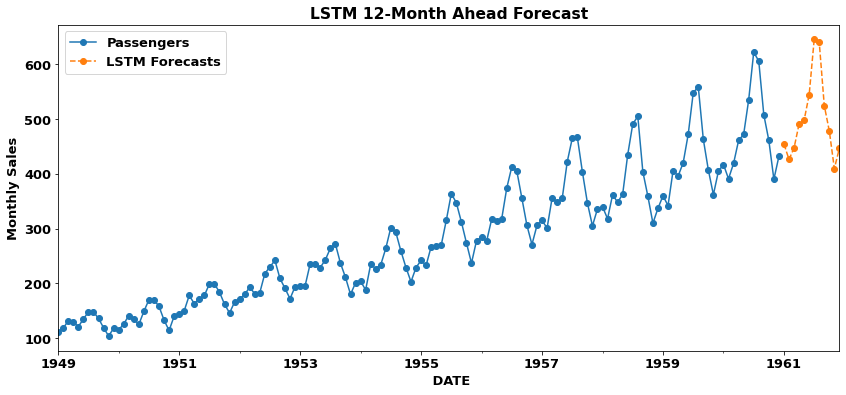

In [49]:
# Plot comprising the original time series,and the 12-month LSTM forecasts

ax=data.plot(figsize=(14,6),marker='o',linestyle='-')
lstm_forecast_df.plot(ax=ax,marker='o',linestyle='--')
plt.title('LSTM 12-Month Ahead Forecast',fontweight='bold')
plt.ylabel('Monthly Sales',fontweight='bold')
plt.xlabel(' DATE',fontweight='bold')

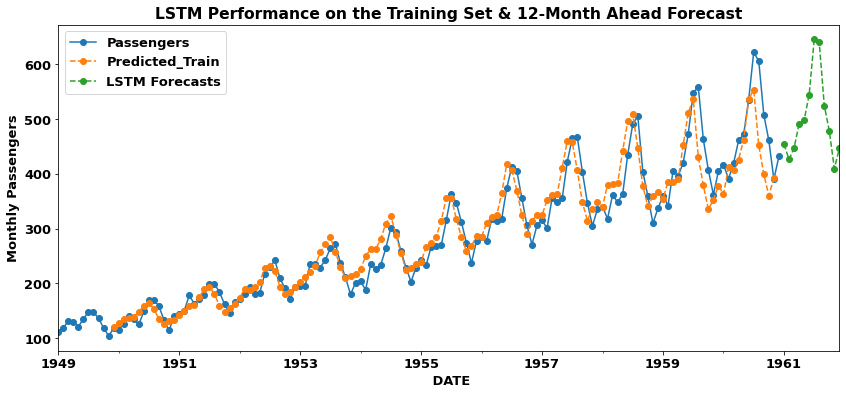

In [50]:
# Plot comprising the LSTM performance on the training set along with the 12-month ahead forecasts
ax=data.plot(figsize=(14,6),marker='o',linestyle='-')
f_train_df.plot(ax=ax,marker='o',linestyle='dashed')
lstm_forecast_df.plot(ax=ax,marker='o',linestyle='--')
plt.title('LSTM Performance on the Training Set & 12-Month Ahead Forecast',fontweight='bold')
plt.ylabel('Monthly Passengers',fontweight='bold')
plt.xlabel(' DATE',fontweight='bold');

ref: https://github.com/tourloukisg/Python-LSTM-Univariate-Time-Series-Forecasting-/blob/master/BeerSales_UnivariateTSeries_Forecast.ipynb